In [1]:
# !apt update -qq && apt install -qq graphviz -y && apt clean && apt autoclean && apt autoremove -yqq
# %pip install --upgrade --no-cache-dir pip wheel setuptools black isort jupyterlab-code-formatter jupyterthemes jupyterlab_darkside_theme nvitop
# %pip install --upgrade --no-cache-dir torch --index-url https://download.pytorch.org/whl/cu121
# %pip install --upgrade --no-cache-dir tensorboard accelerate flash-attn torchtnt bitsandbytes transformers
# %pip install --upgrade --no-cache-dir torcheval torchmetrics torchtnt
# %pip install --upgrade --no-cache-dir optuna
# %pip install --upgrade --no-cache-dir torchviz
# %pip install  --upgrade --no-cache-dir scikit-learn scikit-learn-intelex
# !rm ~/.cache/matplotlib -rf

In [2]:
import datetime
import os
import pickle
import warnings
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor
from copy import deepcopy
from gc import collect
from glob import glob
from pprint import pprint
from typing import Dict

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import torch
import torchmetrics
from sklearn.cluster import *
from sklearn.metrics import davies_bouldin_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer, StandardScaler
from sklearnex import patch_sklearn
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

warnings.simplefilter(action="ignore", category=FutureWarning)

patch_sklearn()
tqdm.pandas()
seed = 42
import random

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


def _collect():
    x = 0
    for i in range(3):
        x += collect()
        torch.cuda.empty_cache()
    return x


# Using 1 year of history data (52 weeks)
window = 52
# Predicting out 8 weeks
n_out = round(window / 2)
early_stop = {"patience": 15, "min_delta": 0.5 * (window * 2) / 10}
resample_period = "1W"
dataset_type = "df_sales"
# Retain only SKU that have at least 10% of data [(1 - max_zeros_in_sku) * 100]
max_zeros_in_sku = 0.9

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
%matplotlib inline

In [4]:
col_to_remove = [
    "amt_disc_ea",
    "amt_gross",
    "amt_net",
    "amt_net_forex",
    "canceled",
    "class_code",
    "code",
    "color_code",
    "cost_center",
    "created_at",
    "currency",
    "customer_code",
    "deleted_at",
    "department_code",
    "discount_granted_excl",
    "discountflag",
    "document_currency",
    "document_number",
    "document_type",
    "family_code",
    "filename",
    "flag_delete",
    "gender_code",
    "geography",
    "gl_account",
    "gl_devise",
    "gl_etablissement",
    "gl_model",
    "gl_numero",
    "gl_numligne",
    "gl_puht",
    "gl_refartbarre",
    "gl_remiseligne",
    "gl_tiers",
    "gl_totalht",
    "gp_refexterne",
    "division",
    "group_code",
    "id",
    "id_class",
    "id_collection",
    "id_color",
    "id_department",
    "id_family",
    "id_gender",
    "id_group",
    "id_loader_job",
    "id_subclass",
    "libdim1",
    "pays",
    "price_ea",
    "product_id",
    "rate",
    "rn",
    "subclass_code",
    "upc",
]

In [5]:
def load_raw_df(
        glob_filter: str = "df_sales*.parquet",
        columns_rename: dict = {
            "gl_datepiece": "date",
            "gl_codearticle": "sku",
            "gl_qtefact": "qty",
        },
):
    df: pd.DataFrame = pd.concat([pd.read_parquet(f) for f in glob(glob_filter)])
    # Removing unuseful columns
    [df.pop(col) for col in col_to_remove if col in df]
    # Renaming columns
    df = df.reset_index(drop=True).rename(columns=columns_rename)

    df["date"] = pd.to_datetime(df["date"])
    df = df.convert_dtypes()

    # Strip text data
    for column in df.select_dtypes(include=[pd.StringDtype]).columns:
        df[column] = df[column].str.strip()

    # Removing null/wrong SKUs - data cleaning on qty
    df = df[~df["sku"].isna()]
    df = df[df["sku"].str.contains(r"\b\w{7}-\w{5}-\w{3}\b")]
    df = df[df["qty"] > 0]

    df["sales_type"] = (
        glob_filter.split("*")[0] if "*" in glob_filter else glob_filter.split(".")[0]
    )
    return df

In [6]:
# raw_dataset_fname = "raw_dataset.parquet"

# if os.path.exists(raw_dataset_fname):
#     df = pd.read_parquet(raw_dataset_fname)
#     # Retain only cegid sales
#     df = df[df["sales_type"] == "df_sales"]
#     dataset_type = "_".join(df["sales_type"].unique())
#     del df["sales_type"]
#     if "date" in df:
#         df.set_index("date", inplace=True)
#     df = df.copy()
# else:
#     df_cl1 = load_raw_df(
#         "cl1_sales*.parquet",
#         {"posting_date": "date", "product_color": "sku", "quantity": "qty"},
#     )
#     df_sales = load_raw_df(
#         "df_sales*.parquet",
#         {"gl_datepiece": "date", "gl_codearticle": "sku", "gl_qtefact": "qty"},
#     )
#     df = pd.concat([df_sales, df_cl1])
#     df.sort_values("date", inplace=True)
#     df.to_parquet(raw_dataset_fname, compression="brotli")
#     df.set_index("date", inplace=True)

# Feature engineering
#### Time
 - Decompose in `t_sin` and `t_cos`
#### Seasons
 - Split `market_seasons` by `|` and concat with `seasons`, `market_season`, `season`
#### Sizes
 - Split `sizes` by `|` and concat with `size`
#### Channels
 - Split `channels` by `|` and concat with `channel`
#### Brands
 - Split `brands` by `|` and concat with `brand`
#### Collections
 - Split `collections` by `|` and concat with `collections`

In [7]:
def get_features(df: pd.DataFrame, col_feature: str):
    features = []
    # Filtering all columns that contains our `col_feature` target
    cols = [col for col in df if col_feature in col]
    for col in cols:
        unique_values = [v for v in df.pop(col).unique() if not pd.isnull(v)]

        for value in unique_values:
            features.extend([v.strip() for v in value.split("|")])
    features = [f for f in list(set(features)) if len(f) > 0]
    df[col_feature] = [features for _ in range(len(df))]

In [8]:
raw_ts_fname = f"raw_timeseries_{dataset_type}_{resample_period}.parquet"
if os.path.exists(raw_ts_fname):
    series = pd.read_parquet(raw_ts_fname)
    if "date" in series:
        series.set_index("date", inplace=True)
else:
    series_list = []
    for sku, _df in tqdm(df.groupby("sku")):
        agg = dict(zip(_df.keys(), ["last"] * len(_df.columns))) | {"qty": "sum"}
        _series = _df.resample(resample_period).agg(agg).ffill().bfill()
        [
            get_features(_series, feature)
            for feature in ["size", "season", "channel", "brand", "collection"]
        ]
        series_list.append(_series)
    series = pd.concat(series_list).sort_index()
    series.to_parquet(raw_ts_fname, compression="brotli")

In [9]:
mask = series.isna().any(axis=1)
print(
    f"Removing {len(series.loc[mask, 'sku'].unique())} SKU that does not have categorical data [{mask.sum()}] weeks"
)
series = series[~mask].copy()

Removing 976 SKU that does not have categorical data [22983] weeks


In [10]:
def create_timeseries(X, cat, y, window=10, n_out=1, shift=0):
    _X, _cat, _y = [], [], []
    for i in range(len(X) - (window + n_out + shift)):
        _X.append(X[i: i + window])
        _cat.append(cat[i])
        _y.append(y[i + window + shift: i + window + shift + n_out])
    return np.asarray(_X), np.asarray(_cat), np.asarray(_y)


print(np.asarray(range(10)))
_x, _cat, _y = create_timeseries(
    np.asarray(range(10)), np.asarray(range(10)), np.asarray(range(10)), 3, 1, 0
)
_x.shape, _cat.shape, _y.shape, _x, _cat, _y

[0 1 2 3 4 5 6 7 8 9]


((6, 3),
 (6,),
 (6, 1),
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6],
        [5, 6, 7]]),
 array([0, 1, 2, 3, 4, 5]),
 array([[3],
        [4],
        [5],
        [6],
        [7],
        [8]]))

In [11]:
# Removing SKUs that do not have at least:
# - 1 example for train and 1 for test
# - 90% of empty data


def filter_sku(df):
    """Filters a single product based on length and zero percentage."""
    if len(df) < (window + n_out + 2):
        return False  # Too short
    zero_percentage = (df["qty"] == 0).sum() / len(df)
    return zero_percentage < max_zeros_in_sku


skus_to_remove = series.groupby("sku").filter(filter_sku)["sku"].unique()
mask = series["sku"].isin(skus_to_remove)
_percent_sku_removed = round(len(skus_to_remove) / len(series["sku"].unique()) * 100, 2)
_percent_entries_removed = round(((mask).sum() / len(series)) * 100, 2)
print(
    f"Removing {_percent_sku_removed}% of SKUs [{_percent_entries_removed}% total entries]"
)
series = series[mask].copy()

Removing 30.98% of SKUs [46.78% total entries]


In [12]:
max_value = series["qty"].max()
for dtype in [np.float16, np.float32, np.float64]:
    if max_value <= np.finfo(dtype).max:
        print(f"Setting dtype: {dtype}")
        series["qty"] = series["qty"].astype(dtype)
        break

Setting dtype: <class 'numpy.float16'>


<Axes: xlabel='date'>

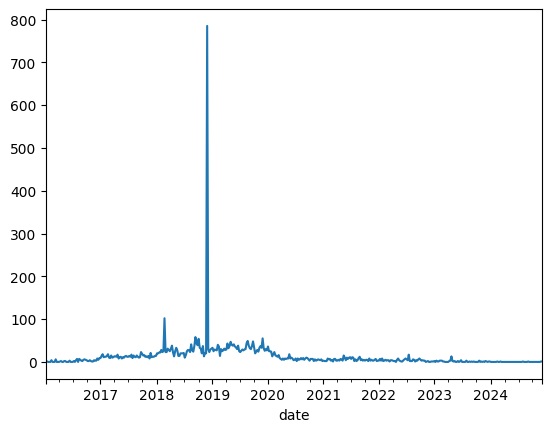

In [13]:
outlier_sku = "MWL150E-00139-100"
_mask = series["sku"] == outlier_sku
data = series.loc[_mask, "qty"]
data.plot()

In [14]:
def remove_outliers(data: pd.Series, n=3) -> (pd.Series, bool):
    # Calculate Z-scores
    mean = data.mean()
    std = data.std()
    data_zscore = (data - mean) / std

    # Identify outliers (e.g., |Z| > 3)
    outliers_z = data[abs(data_zscore) > n]
    has_outliers = len(outliers_z) > 0
    clip_data = None
    if has_outliers:
        clip_data = data.clip(upper=mean + n * std, lower=mean - n * std)

    return clip_data, has_outliers

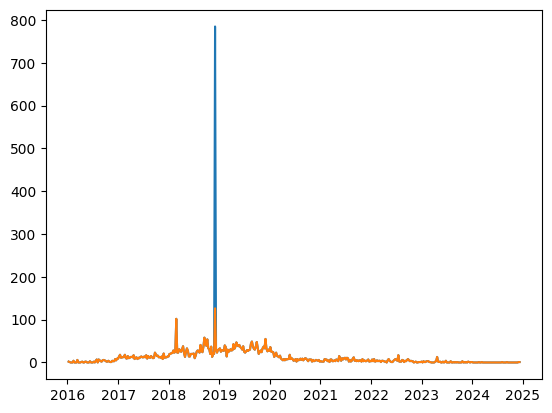

In [15]:
_data, has_outliers = remove_outliers(data.astype(float))
plt.plot(data)
plt.plot(_data)

In [16]:
n_outliers = 0
filtered_ts_fname = f"filtered_timeseries_{dataset_type}_{resample_period}_{max_zeros_in_sku}_{window}_{n_out}.parquet"
if os.path.exists(filtered_ts_fname):
    series = pd.read_parquet(filtered_ts_fname)
else:
    for sku in tqdm(series["sku"].unique()):
        mask = series["sku"] == sku
        data, has_outliers = remove_outliers(series.loc[mask, "qty"])
        if has_outliers:
            n_outliers += 1
            series.loc[mask, "qty"] = data
    print(f"Removed {n_outliers} outliers")
    series = series.convert_dtypes()
    series.to_parquet(filtered_ts_fname, compression="brotli")

  0%|          | 0/40 [00:00<?, ?it/s]

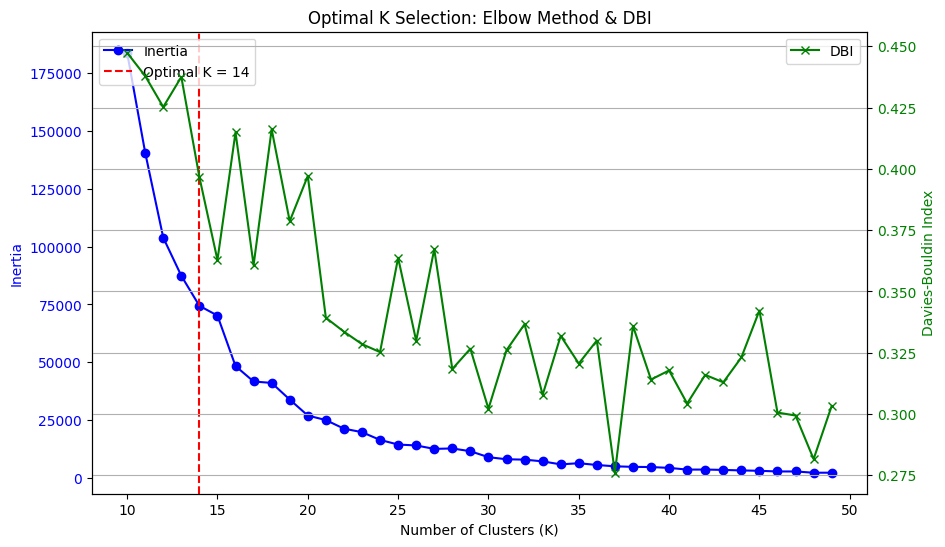

Optimal K: 14


In [17]:

def find_best_k(data, k_range=range(10, 50), random_state=42):
    inertia_values = []
    dbi_scores = []

    for k in tqdm(k_range):
        kmeans = KMeans(n_clusters=k, random_state=42, max_iter=1000, tol=1e6)
        kmeans.fit(data)
        inertia_values.append(kmeans.inertia_)
        dbi_scores.append(davies_bouldin_score(data, kmeans.labels_))

    # Determine the "elbow point" for inertia
    deltas = np.diff(inertia_values)
    elbow_point = np.argmin(np.diff(deltas)) + k_range.start  # Adjust for indexing

    # Plot the Elbow Method and DBI
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Inertia plot
    ax1.plot(k_range, inertia_values, marker="o", label="Inertia", color="blue")
    ax1.set_xlabel("Number of Clusters (K)")
    ax1.set_ylabel("Inertia", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")

    # DBI plot
    ax2 = ax1.twinx()
    ax2.plot(k_range, dbi_scores, marker="x", label="DBI", color="green")
    ax2.set_ylabel("Davies-Bouldin Index", color="green")
    ax2.tick_params(axis="y", labelcolor="green")

    # Highlight the optimal K
    ax1.axvline(
        x=elbow_point, color="red", linestyle="--", label=f"Optimal K = {elbow_point}"
    )
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")

    plt.title("Optimal K Selection: Elbow Method & DBI")
    plt.grid()
    plt.show()

    return {
        "kmeans": KMeans(
            n_clusters=elbow_point, random_state=42, max_iter=1000, tol=1e6
        ),
        "best_k": elbow_point,
        "inertia_values": inertia_values,
        "dbi_scores": dbi_scores,
    }


results = find_best_k(series[["qty"]])
print("Optimal K:", results["best_k"])
kmeans = results["kmeans"]
series["bins"] = kmeans.fit_predict(series[["qty"]])

# Creating categorical features

In [18]:
categorical_features = [
    c for c in series.columns if c not in {"sku", "qty", "description", "bins"}
]
categorical_features

['composition',
 'gender_description',
 'department_description',
 'class_description',
 'group_description',
 'color_description',
 'family_description',
 'subclass_description',
 'size',
 'season',
 'channel',
 'brand',
 'collection']

In [19]:
label_encoders = {c: MultiLabelBinarizer() for c in categorical_features} | {
    "bins": LabelBinarizer()
}
label_encoders

{'composition': MultiLabelBinarizer(),
 'gender_description': MultiLabelBinarizer(),
 'department_description': MultiLabelBinarizer(),
 'class_description': MultiLabelBinarizer(),
 'group_description': MultiLabelBinarizer(),
 'color_description': MultiLabelBinarizer(),
 'family_description': MultiLabelBinarizer(),
 'subclass_description': MultiLabelBinarizer(),
 'size': MultiLabelBinarizer(),
 'season': MultiLabelBinarizer(),
 'channel': MultiLabelBinarizer(),
 'brand': MultiLabelBinarizer(),
 'collection': MultiLabelBinarizer(),
 'bins': LabelBinarizer()}

In [ ]:
for column, label_encoder in tqdm(label_encoders.items()):
    label_encoder.fit(series[column].reset_index(drop=True))
    series[f"encoded_{column}"] = label_encoder.transform(
        series[column].reset_index(drop=True)
    ).tolist()

  0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
sku_to_index = {sku: idx for idx, sku in enumerate(series["sku"].unique())}
series["sku_code"] = series["sku"].map(sku_to_index)

In [ ]:
# Create time features. Decompose the time "signal" using cos and sin coordinates.
# By this, the first week of the year is nearest point of the last week instead of the farthest.
# FIXME: We use only the week number (1-52 i think), add features related to holiday and month instead of the week number only)
# FIXME: Take care about the COVID period in order to add an external bias factor for influence the 2020-2022 sales.
#   Note that batch size can influence the generalization of the network and reduce the sales due to the decrease of the sales.
calendar = series.index.isocalendar().week
series["t_sin"] = np.sin(calendar * (2 * np.pi / calendar.max()))
series["t_cos"] = np.cos(calendar * (2 * np.pi / calendar.max()))

display(series[series["sku"] == "MJQ008H-00535-461"][["t_sin", "t_cos"]].plot())
t = series[series["sku"] == "MJQ008H-00535-461"][["qty"]]
t["rolling_mean"] = t["qty"].rolling(2).mean()
t.plot()

In [ ]:
sku_list = series.pop("sku")

In [ ]:
encoded_categorical_features = [c for c in series.columns if "encoded" in c]
series_fname = (
    f"series_{dataset_type}_{max_zeros_in_sku}_{window}_{n_out}_with_bins.pkl"
)
if os.path.exists(series_fname):
    with open(series_fname, "rb") as f:
        (
            ts_train_x_dataset,
            ts_train_cat_dataset,
            ts_train_y_dataset,
            ts_test_x_dataset,
            ts_test_cat_dataset,
            ts_test_y_dataset,
        ) = pickle.load(f)
else:
    ts_train_x_dataset = []
    ts_train_cat_dataset = []
    ts_train_y_dataset = []
    ts_test_x_dataset = []
    ts_test_cat_dataset = []
    ts_test_y_dataset = []
    grouped = series.groupby("sku_code")
    series_features = [
        "qty",
        "sku_code",
        "t_sin",
        "t_cos",
    ]


    #     for idx, (sku, _series) in enumerate(tqdm(grouped)):
    #         categorical_data = (
    #             _series[encoded_categorical_features]
    #             .iloc[0]
    #             .apply(lambda x: np.asarray(x, dtype=np.bool_))
    #             .values
    #         )

    #         _ts, _cat, _y = create_timeseries(
    #             _series[series_features].values,
    #             [categorical_data] * len(_series),
    #             _series[["qty", "encoded_bins"]].values,
    #             window=window,
    #             n_out=n_out,
    #         )

    #         _ts_train, _ts_test, _cat_train, _cat_test, _y_train, _y_test = (
    #             train_test_split(_ts, _cat, _y, test_size=0.2, shuffle=False)
    #         )
    #         ts_train_x_dataset.extend(_ts_train)
    #         ts_test_x_dataset.extend(_ts_test)
    #         ts_train_cat_dataset.extend(_cat_train)
    #         ts_test_cat_dataset.extend(_cat_test)
    #         ts_train_y_dataset.extend(_y_train)
    #         ts_test_y_dataset.extend(_y_test)

    def process_group(_series, window, n_out):
        categorical_data = (
            _series[encoded_categorical_features]
            .iloc[0]
            .apply(lambda x: np.asarray(x, dtype=np.bool_))
            .values
        )
        _ts, _cat, _y = create_timeseries(
            _series[series_features].values,
            [categorical_data] * len(_series),
            _series[["qty", "encoded_bins"]].values,
            window=window,
            n_out=n_out,
        )
        return train_test_split(_ts, _cat, _y, test_size=0.2, shuffle=False)


    results = []
    with ThreadPoolExecutor() as executor:
        for idx, (sku, _series) in enumerate(tqdm(grouped)):
            results.append(
                executor.submit(process_group, _series, window, n_out)
            )

    for future in tqdm(results):
        _ts_train, _ts_test, _cat_train, _cat_test, _y_train, _y_test = future.result()
        ts_train_x_dataset.extend(_ts_train)
        ts_test_x_dataset.extend(_ts_test)
        ts_train_cat_dataset.extend(_cat_train)
        ts_test_cat_dataset.extend(_cat_test)
        ts_train_y_dataset.extend(_y_train)
        ts_test_y_dataset.extend(_y_test)

    ts_train_x_dataset = np.asarray(ts_train_x_dataset)
    ts_train_y_dataset = np.asarray(ts_train_y_dataset)
    ts_train_cat_dataset = np.asarray(ts_train_cat_dataset)
    ts_test_x_dataset = np.asarray(ts_test_x_dataset)
    ts_test_y_dataset = np.asarray(ts_test_y_dataset)
    ts_test_cat_dataset = np.asarray(ts_test_cat_dataset)
    with open(series_fname, "wb") as f:
        pickle.dump(
            (
                ts_train_x_dataset,
                ts_train_cat_dataset,
                ts_train_y_dataset,
                ts_test_x_dataset,
                ts_test_cat_dataset,
                ts_test_y_dataset,
            ),
            f,
            pickle.HIGHEST_PROTOCOL,
        )
del series
_collect()
ts_train_x_dataset.shape, ts_train_cat_dataset.shape, ts_train_y_dataset.shape

In [ ]:
scaler_x = StandardScaler().fit(ts_train_x_dataset[:, :, 0])
scaler_y = StandardScaler().fit(ts_train_y_dataset[:, :, 0])

ts_train_x_dataset[:, :, 0] = scaler_x.transform(ts_train_x_dataset[:, :, 0])
ts_test_x_dataset[:, :, 0] = scaler_x.transform(ts_test_x_dataset[:, :, 0])

ts_train_y_dataset[:, :, 0] = scaler_y.transform(ts_train_y_dataset[:, :, 0])
ts_test_y_dataset[:, :, 0] = scaler_y.transform(ts_test_y_dataset[:, :, 0])

In [ ]:
for x, cat, y in zip(ts_test_x_dataset, ts_test_cat_dataset, ts_test_y_dataset):
    print(x.shape, [_.shape for _ in cat], y.shape)
    break

In [ ]:
class DemandDataset(Dataset):
    def __init__(self, raw_dataset, cat_dataset, y):
        self.raw_dataset = raw_dataset
        self.cat_dataset = cat_dataset
        self.y = y

    def __len__(self):
        return len(self.raw_dataset)

    def __getitem__(self, idx):
        return {
            "sequence": self.raw_dataset[idx],
            "y": self.y[idx],
            "categorical_data": self.cat_dataset[idx],
        }

    def collate_fn(self, batch):
        qty = torch.as_tensor(
            np.asarray([x["sequence"][:, 0] for x in batch], dtype=np.float32),
            dtype=torch.float32,
        ).unsqueeze(-1)
        sku = torch.as_tensor(
            np.asarray([x["sequence"][:, 1][0] for x in batch], dtype=np.int32),
            dtype=torch.int32,
        )
        time = torch.as_tensor(
            np.asarray([x["sequence"][:, 2:] for x in batch], dtype=np.float32),
            dtype=torch.float32,
        )
        y = torch.as_tensor(
            np.asarray([x["y"][:, 0] for x in batch], dtype=np.float32),
            dtype=torch.float32,
        )

        y_cat = []
        for entry in batch:
            x = np.vstack(entry["y"][:, 1])
            y_cat.append(x)

        cats = defaultdict(list)
        for entry in batch:
            v = dict(zip(encoded_categorical_features, entry["categorical_data"]))
            for k, v in v.items():
                cats[k].append(v)
        for k in cats:
            cats[k] = torch.as_tensor(np.asarray(cats[k]), dtype=torch.bool)

        return {
            "qty": qty,
            "sku": sku,
            "time": time,
            "y": y,
            "y_cat": torch.as_tensor(np.asarray(y_cat), dtype=torch.float32),
            "cats": cats,
        }

# _collect()

In [ ]:
batch_size = 512
num_workers = 4


def init_ds(batch_size, num_workers):
    pin_memory = True
    device = torch.device("cpu")

    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2 ** 32
        np.random.seed(worker_seed)
        random.seed(worker_seed)

    g = torch.Generator()
    g.manual_seed(seed)
    if not torch.cuda.is_available():
        pin_memory = False
        num_workers = 0
        batch_size = 32

    ds_train = DemandDataset(
        ts_train_x_dataset, ts_train_cat_dataset, ts_train_y_dataset
    )
    dl_train = DataLoader(
        ds_train,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=ds_train.collate_fn,
        pin_memory=pin_memory,
        drop_last=True,
        worker_init_fn=seed_worker,
        generator=g,
    )

    ds_test = DemandDataset(ts_test_x_dataset, ts_test_cat_dataset, ts_test_y_dataset)
    dl_test = DataLoader(
        ds_test,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=ds_test.collate_fn,
        pin_memory=pin_memory,
        drop_last=True,
        worker_init_fn=seed_worker,
        generator=g,
    )
    if torch.cuda.is_available():
        device = torch.device("cuda")
        from torchtnt.utils.data import CudaDataPrefetcher

        dl_train = CudaDataPrefetcher(dl_train, device, 8)
        dl_test = CudaDataPrefetcher(dl_test, device, 8)
    return device, dl_train, dl_test, ds_train, ds_test


def init_metrics():
    metrics_names = [v for v in dir(torchmetrics.regression) if v[0].isupper()]
    metrics = {}
    target = torch.tensor([[2.5, 5, 4, 8], [3, 5, 2.5, 7]])
    preds = torch.tensor([[3, 5, 2.5, 7], [2.5, 5, 4, 8]])
    for metric_name in metrics_names:
        try:
            metric = getattr(torchmetrics, metric_name)()
            metric(preds, target)
            metrics[metric_name] = metric
        except Exception as e:
            print("Skipping ", metric_name, e)
    del metrics["KLDivergence"]
    del metrics["CosineSimilarity"]
    return metrics


device, dl_train, dl_test, ds_train, ds_test = init_ds(batch_size, num_workers)
metrics = init_metrics()

In [ ]:
for x_ds in ds_train:
    break
for x_dl in dl_train:
    break

In [ ]:
encoded_features_shape = {}
for k, v in x_dl.items():
    if k == "cats":
        encoded_features_shape.update(
            {"cats": {k: _v.shape[-1] for k, _v in v.items()}}
        )
    else:
        encoded_features_shape.update({k: v.shape[-1]})
pprint(encoded_features_shape)
sku_vocab_size = len(sku_to_index)
cat_features_shapes = encoded_features_shape["cats"]
time_features_dim = encoded_features_shape["time"]

del x_ds, x_dl
_collect()

In [ ]:
def plot_model(model, batch):
    from torchviz import make_dot

    qty = batch["qty"]  # [batch_size, 52, 1]
    time = batch["time"]  # [batch_size, 52, 2]
    sku = batch["sku"]  # [batch_size]
    cats = {key: value.to(dtype=torch.int32) for key, value in batch["cats"].items()}

    # Forward pass return both regression and classification
    outputs, class_preds = model(qty, time, sku, cats)
    return make_dot((outputs, class_preds), params=dict(model.named_parameters()))

In [ ]:
class DemandForecastingModel(nn.Module):
    def __init__(
            self,
            sku_vocab_size: int,
            sku_emb_dim: int,
            cat_features_dim: Dict[str, int],
            cat_emb_dims: int,
            time_features_dim: int,
            lstm_bidirectional: bool,
            lstm_hidden_size: int,
            lstm_layers: int,
            linear_hidden_size: int,
            dropout: float,
            n_out: int,
    ):
        super(DemandForecastingModel, self).__init__()
        # SKU Embedding
        self.sku_embedding = nn.Embedding(sku_vocab_size, sku_emb_dim)

        # Categorical Feature Embeddings
        self.cat_embeddings = nn.ModuleDict(
            {
                name: nn.Embedding(vocab_size, emb_dim)
                for name, vocab_size, emb_dim in zip(
                cat_features_dim.keys(),
                cat_features_dim.values(),
                [cat_emb_dims] * len(cat_features_dim),
            )
            }
        )

        # LSTM for time-series data
        self.lstm = nn.LSTM(
            input_size=1 + time_features_dim,  # qty (1) + time (2)
            hidden_size=lstm_hidden_size,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=lstm_bidirectional,
            dropout=dropout,
        )
        out_lstm_hidden_size = lstm_hidden_size
        if lstm_bidirectional:
            out_lstm_hidden_size = lstm_hidden_size * 2
        # Fully connected layer for final predictions
        total_cat_emb_dim = cat_emb_dims * len(cat_features_dim) + sku_emb_dim
        self.fc = nn.Sequential(
            nn.Linear(
                out_lstm_hidden_size + total_cat_emb_dim,
                (out_lstm_hidden_size + total_cat_emb_dim) // 2,
            ),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(
                (out_lstm_hidden_size + total_cat_emb_dim) // 2, lstm_hidden_size
            ),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(lstm_hidden_size, n_out),
        )

        self.fc_class = nn.Sequential(
            nn.Linear(
                out_lstm_hidden_size + total_cat_emb_dim,
                (out_lstm_hidden_size + total_cat_emb_dim) // 2,
            ),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(
                (out_lstm_hidden_size + total_cat_emb_dim) // 2, linear_hidden_size
            ),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(linear_hidden_size, cat_features_shapes["encoded_bins"] * n_out),
        )

    def forward(self, qty, time, sku, cats):
        # SKU Embedding
        sku_emb = self.sku_embedding(sku)

        # Categorical Embeddings
        # FIXME: We are using the `mean`, migrate to MaxPool/Attention or other smarter ways
        cat_embs = [
            emb(cats[name]).mean(axis=1) for name, emb in self.cat_embeddings.items()
        ]

        cat_embs = torch.cat(cat_embs, dim=1)  # [batch_size, total_cat_emb_dim]

        # FIXME: Use an LSTM for the QTY and one for the TIME?
        # Time-Series Data Processing
        x = torch.cat([qty, time], dim=-1)  # Combine qty and time [batch_size, 52, 3]
        lstm_out, _ = self.lstm(
            x
        )  # [batch_size, window, lstm_hidden_size * (2 * lstm_bidirectional)]
        # Take the last time step [batch_size, lstm_hidden_size * (2 * lstm_bidirectional)]
        lstm_out = lstm_out[:, -1, :]

        # Feature Fusion
        # [batch_size, lstm_hidden_size * (2 * lstm_bidirectional) + total_cat_emb_dim]
        combined_features = torch.cat([lstm_out, sku_emb, cat_embs], dim=-1)

        # Final Prediction
        output = self.fc(combined_features)  # [batch_size, n_out]

        classification_logits = self.fc_class(
            combined_features
        )  # [batch_size, n_out * num_classes]

        # Reshape for classification output: [batch_size, n_out, num_classes]
        classification_output = classification_logits.view(
            -1, n_out, cat_features_shapes["encoded_bins"]
        )

        return output, classification_output

In [ ]:
def core(batch, regression_criterion, classification_criterion, model, flatten=True):
    qty = batch["qty"]  # [batch_size, 52, 1]
    time = batch["time"]  # [batch_size, 52, 2]
    sku = batch["sku"]  # [batch_size]
    # Maybe it is not necessary. To save memory, we save the categorical matrix data as boolean (True/False instead of 1/0)
    cats = {key: value.to(dtype=torch.int32) for key, value in batch["cats"].items()}
    y_class = torch.argmax(batch["y_cat"], dim=-1)  # [batch_size, n_out]
    targets = batch["y"]

    # Forward pass return both regression and classification
    outputs, class_preds = model(qty, time, sku, cats)
    # Use the sum of each value to reduce "global batch distance" from targets (from `[batch_size, n_out]` to `[batch_size]`)
    if flatten:
        flatten_outputs = torch.sum(outputs, dim=-1)
        flatten_targets = torch.sum(targets, dim=-1)
    else:
        flatten_outputs = outputs
        flatten_targets = targets

    # Compute regression loss
    regression_loss = regression_criterion(flatten_outputs, flatten_targets)

    # Compute classification loss (targets should be [batch_size, n_out])
    classification_loss = classification_criterion(
        # Flatten classification logits to [batch_size * n_out, num_classes]
        class_preds.view(-1, class_preds.size(-1)),
        # Flatten targets to [batch_size * n_out]
        y_class.view(-1),
    )

    # Combine losses with a weighting factor
    alpha = 1.0  # Weight for regression loss
    beta = 1.0  # Weight for classification loss
    loss = alpha * regression_loss + beta * classification_loss

    return loss, outputs, targets, flatten_outputs, flatten_targets


# Validation on the test dataset
def validate_model(
        model,
        dataloader,
        regression_criterion,
        classification_criterion,
        batch_size,
        plot=False,
):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    flatten_predictions, flatten_actuals, predictions, actuals = [], [], [], []
    _skus = []
    if device.type == "cuda":
        total_steps = len(dataloader.data_iterable.dataset) // batch_size
    else:
        total_steps = len(dataloader.dataset) // batch_size

    with torch.no_grad():
        for batch in tqdm(dataloader, total=total_steps, leave=False):
            loss, outputs, targets, flatten_outputs, flatten_targets = core(
                batch, regression_criterion, classification_criterion, model
            )
            total_loss += loss.item()

            # Store predictions and actual values
            flatten_predictions.extend(flatten_outputs.squeeze().detach().cpu().numpy())
            flatten_actuals.extend(flatten_targets.detach().cpu().numpy())
            predictions.extend(outputs.squeeze().detach().cpu().numpy())
            actuals.extend(targets.detach().cpu().numpy())
            _skus.extend(batch["sku"].detach().cpu().numpy())

    avg_loss = total_loss / total_steps

    # Calculate performance metrics
    _actuals = np.array(actuals)
    _predictions = np.array(predictions)
    res = _actuals - _predictions

    _flatten_actuals = np.array(flatten_actuals)
    _flatten_predictions = np.array(flatten_predictions)
    flatten_res = _flatten_actuals - _flatten_predictions

    mse = np.mean(res ** 2)
    mae = np.mean(np.abs(res))
    flatten_mse = np.mean(flatten_res ** 2)
    flatten_mae = np.mean(np.abs(flatten_res))

    # Plot predictions vs actuals
    s_res = f"Loss: {avg_loss:.4f} MSE: {mse:.4f} MAE: {mae:.4f} FLAT_MSE: {flatten_mse:.4f} FLAT_MAE: {flatten_mae:.4f}"
    if plot:
        plt.figure(figsize=(20, 10))
        plt.plot(flatten_actuals, label="Actual", color="blue")
        plt.plot(
            flatten_predictions, label="Predicted", color="red", linestyle="dashed"
        )
        plt.title(s_res)
        plt.xlabel("Sample Index")
        plt.ylabel("Quantity")
        plt.legend(loc="upper right")
        plt.grid()
        plt.show()

    print(f"Validation Results:\n{s_res}")
    _p, _a = torch.as_tensor(flatten_predictions), torch.as_tensor(flatten_actuals)
    _res_metric = {}
    for metric_name, metric in metrics.items():
        try:
            _res_metric[metric_name] = metric(_p, _a).item()
        except Exception:
            print("skipping", metric_name)

    return {
        "predictions": predictions,
        "actuals": actuals,
        "flatten_predictions": flatten_predictions,
        "flatten_actuals": flatten_actuals,
        "skus": _skus,
        "avg_loss": avg_loss,
        "mse": mse,
        "mae": mae,
        "flatten_mse": flatten_mse,
        "flatten_mae": flatten_mae,
        "metrics": _res_metric,
    }


# Training Loop
def train_model(
        model,
        dataloader_train,
        dataloader_test,
        regression_criterion,
        classification_criterion,
        optimizer,
        scheduler,
        num_epochs,
        batch_size,
        device,
        early_stop: Dict[str, int] = early_stop,
        plot_n_epochs=1000,
        flatten=True,
):
    if device.type == "cuda":
        total_steps = len(dataloader_train.data_iterable.dataset) // batch_size
    else:
        total_steps = len(dataloader_train.dataset) // batch_size

    best_metric = float("inf")
    epochs_no_improve = 0
    best_model = None

    for epoch in tqdm(range(num_epochs), desc="epochs", position=0):
        epoch_loss = 0.0
        model.train()
        for batch in tqdm(dataloader_train, position=1, leave=False, total=total_steps):
            loss, _, _, _, _ = core(
                batch, regression_criterion, classification_criterion, model, flatten
            )

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / total_steps:.4f}")
        val_metrics = validate_model(
            model,
            dataloader_test,
            regression_criterion,
            classification_criterion,
            batch_size,
            plot=(epoch + 1) % plot_n_epochs == 0,
        )

        flatten_mse = val_metrics["flatten_mse"]
        scheduler.step(flatten_mse)
        if flatten_mse < best_metric:
            best_model = deepcopy(model.state_dict())
        if flatten_mse < best_metric - early_stop["min_delta"]:
            epochs_no_improve = 0
            best_metric = flatten_mse
        else:
            epochs_no_improve += 1
            if epochs_no_improve == early_stop["patience"]:
                print(f"Early stopping triggered after {epoch + 1} epochs!")

                model.load_state_dict(best_model)  # load the best model
                return
                #     _collect()

In [ ]:
trials_params = {}


def objective(trial: optuna.Trial) -> float:
    # Define the hyperparameters to tune
    sku_emb_dim = trial.suggest_categorical("sku_emb_dim", choices=[4, 8, 16, 32])
    cat_emb_dims = trial.suggest_categorical("cat_emb_dims", choices=[4, 8, 16, 32])
    lstm_hidden_size = trial.suggest_categorical(
        "lstm_hidden_size", choices=[32, 64, 96]
    )
    linear_hidden_size = trial.suggest_categorical(
        "linear_hidden_size", choices=[128, 192, 256, 512]
    )
    lstm_bidirectional = trial.suggest_categorical(
        "lstm_bidirectional", choices=[True, False]
    )
    lstm_layers = trial.suggest_categorical("lstm_layers", choices=[2, 3, 4])
    learning_rate = trial.suggest_categorical(
        "learning_rate", choices=[0.01, 0.001, 0.0001]
    )
    dropout = trial.suggest_categorical("dropout", choices=[0.3, 0.4])
    flatten = trial.suggest_categorical("flatten", choices=[True, False])
    batch_size = trial.suggest_categorical(
        "batch_size", choices=[512, 1024, 2048, 4096]
    )

    params = [
        sku_emb_dim,
        cat_emb_dims,
        lstm_hidden_size,
        linear_hidden_size,
        lstm_bidirectional,
        lstm_layers,
        learning_rate,
        dropout,
        batch_size,
    ]
    key = "_".join(map(str, params))
    if key in trials_params:
        print(f"Skipping trial {trial.params} [already run]")
        return trials_params[key]
    num_epochs = 20

    device, dl_train, dl_test, ds_train, ds_test = init_ds(batch_size, 3)
    model = DemandForecastingModel(
        sku_vocab_size,
        sku_emb_dim,
        cat_features_shapes,
        cat_emb_dims,
        time_features_dim,
        lstm_bidirectional,
        lstm_hidden_size,
        lstm_layers,
        linear_hidden_size,
        dropout,
        n_out,
    ).to(device)

    # Define the loss functions and optimizer
    regression_criterion = nn.MSELoss()
    classification_criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        patience=5,
        factor=0.1,
        threshold=early_stop["min_delta"],
        mode="min",
        verbose=True,
    )

    # Train the model
    train_model(
        model,
        dl_train,
        dl_test,
        regression_criterion,
        classification_criterion,
        optimizer,
        scheduler,
        num_epochs,
        batch_size,
        device,
        early_stop={"patience": 7, "min_delta": 0.3},
        flatten=flatten,
    )

    # Validate the model
    val_metrics = validate_model(
        model,
        dl_test,
        regression_criterion,
        classification_criterion,
        batch_size,
        True,
    )
    # pprint(val_metrics['metrics'])
    _collect()
    trials_params[key] = val_metrics["flatten_mse"]
    return val_metrics["flatten_mse"]


study_name = "study-v6"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)

sampler = optuna.samplers.TPESampler(seed=seed)
sampler_fname = f"{study_name}-sampler.pkl"
if os.path.exists(sampler_fname):
    sampler = pickle.load(open(sampler_fname, "rb"))
else:
    with open(f"{study_name}-sampler.pkl", "wb") as fout:
        pickle.dump(sampler, fout)
try:
    study = optuna.create_study(
        direction="minimize",
        study_name=study_name,
        storage=storage_name,
        load_if_exists=True,
        sampler=sampler,
    )
    # Optimize the study
    study.optimize(
        objective,
        timeout=datetime.timedelta(hours=10).seconds,
        gc_after_trial=True,
        show_progress_bar=True,
        catch=[Exception],
    )
except Exception as e:
    with open(f"{study_name}-sampler.pkl", "wb") as fout:
        pickle.dump(sampler, fout)
    df_optuna = study.trials_dataframe().sort_values(["value"])
    df_optuna.to_csv(f"{study_name}.csv", index=False)

# Print the best parameters and value
df_optuna = study.trials_dataframe().sort_values(["value"])
df_optuna.to_csv(f"{study_name}.csv", index=False)
param_column = [col for col in df_optuna.columns if "param" in col]
df_optuna.drop_duplicates(param_column, inplace=True)
df_optuna.head(20)
df_optuna

In [ ]:
# df_optuna = pd.read_csv(f"{study_name}.csv")
# param_column = [col for col in df_optuna.columns if "param" in col]
# df_optuna.drop_duplicates(param_column, inplace=True)
# df_optuna.head(20)

In [ ]:
# from optuna.visualization import (
#     plot_contour,
#     plot_edf,
#     plot_intermediate_values,
#     plot_optimization_history,
#     plot_parallel_coordinate,
#     plot_param_importances,
#     plot_rank,
#     plot_slice,
#     plot_timeline,
# )
# from plotly.io import show

# base_folder = f"plotly/{study_name}/"
# os.makedirs(base_folder, exist_ok=True)
# for _plot in [
#     plot_contour,
#     plot_edf,
#     plot_intermediate_values,
#     plot_optimization_history,
#     plot_parallel_coordinate,
#     plot_param_importances,
#     plot_rank,
#     plot_slice,
#     plot_timeline,
# ]:

#     fig = _plot(study)
#     fig.write_html(f"{base_folder}/{_plot.__str__().split(' ')[1]}.html")

In [ ]:
# Hyperparameters

# Validation Results:
# Loss: 6.5264 MSE: 0.3602 MAE: 0.3792 FLAT_MSE: 5.8447 FLAT_MAE: 1.1405
# {'ExplainedVariance': 0.841219425201416,
#  'MeanAbsoluteError': 1.1405441761016846,
#  'MeanAbsolutePercentageError': 1.5009294748306274,
#  'MeanSquaredError': 5.844719409942627,
#  'MeanSquaredLogError': nan,
#  'NormalizedRootMeanSquaredError': -6.815373420715332,
#  'R2Score': 0.8384091258049011,
#  'SymmetricMeanAbsolutePercentageError': 0.5042175650596619,
#  'TweedieDevianceScore': 5.844719409942627,
#  'WeightedMeanAbsolutePercentageError': 0.3787154257297516}
# [I 2024-12-24 22:55:31,254] Trial 2 finished with value: 5.844719409942627 and parameters: {'sku_emb_dim': 16, 'cat_emb_dims': 128, 'lstm_hidden_size': 196, 'linear_hidden_size': 200, 'lstm_layers': 2, 'learning_rate': 0.0001, 'dropout': 0.2, 'batch_size': 256}. Best is trial 2 with value: 5.844719409942627.
# number	value	datetime_start	datetime_complete	duration	params_batch_size	params_cat_emb_dims	params_dropout	params_learning_rate	params_linear_hidden_size	params_lstm_hidden_size	params_lstm_layers	params_sku_emb_dim	state
# 1	23	5.675551891326904	2024-12-25 04:11:22.307206	2024-12-25 04:14:56.267902	0 days 00:03:33.960696	1024	32	0.4	0.001	192	64	3	4	COMPLETE
sku_emb_dim = 4
cat_emb_dims = 32
linear_hidden_size = 192
lstm_hidden_size = 64
lstm_bidirectional = False
lstm_layers = 3
learning_rate = 0.001
batch_size = 1024
num_epochs = 50
dropout = 0.4
flatten = False

_collect()
device, dl_train, dl_test, _, _ = init_ds(batch_size, 4)

model = DemandForecastingModel(
    sku_vocab_size,
    sku_emb_dim,
    cat_features_shapes,
    cat_emb_dims,
    time_features_dim,
    lstm_bidirectional,
    lstm_hidden_size,
    lstm_layers,
    linear_hidden_size,
    dropout,
    n_out,
).to(device)

# for batch in dl_train:
#     break
# dot = plot_model(model, batch)
# dot.format = "svg"
# dot.render()
# del batch

# Define the loss functions and optimizer
regression_criterion = nn.MSELoss()
classification_criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    patience=5,
    factor=0.1,
    threshold=early_stop["min_delta"],
    mode="min",
    verbose=True,
)
train_model(
    model,
    dl_train,
    dl_test,
    regression_criterion,
    classification_criterion,
    optimizer,
    scheduler,
    num_epochs,
    batch_size,
    device,
    flatten=flatten,
    early_stop=early_stop,
)

In [ ]:
import numpy as np
import torch
from scipy.stats import norm


def calculate_confidence_intervals(predictions, y, confidence=0.95):
    """
    Calcola le bande di confidenza assumendo normalità degli errori.

    Args:
        predictions (torch.Tensor): Previsioni del modello.
        y (torch.Tensor o np.array): Valori reali.
        confidence (float): Livello di confidenza (es. 0.95 per il 95%).

    Returns:
        tuple: Tuple contenente le bande di confidenza inferiori e superiori.
        None: se y non ha la stessa forma di predictions
    """
    if not isinstance(y, torch.Tensor):
        y = torch.from_numpy(y)
    if not isinstance(predictions, torch.Tensor):
        predictions = torch.from_numpy(predictions)

    if predictions.shape != y.shape:
        print("Errore: predictions e y devono avere la stessa forma.")
        return None

    errors = y - predictions

    if errors.dim() > 1:  # gestisci il caso di batch
        std_devs = errors.std(
            dim=0
        )  # calcola la deviazione standard su tutti gli elementi del batch per ogni timestep
    else:
        std_dev = torch.std(errors)
        std_devs = torch.full_like(
            predictions, std_dev
        )  # crea un tensore con la std_dev per ogni timestep

    z = norm.ppf(1 - (1 - confidence) / 2)

    lower_bounds = predictions - (z * std_devs)
    upper_bounds = predictions + (z * std_devs)

    return lower_bounds, upper_bounds

In [ ]:
# Validate the model on the test dataset
val_metrics = validate_model(
    model, dl_test, regression_criterion, classification_criterion, batch_size, True
)

In [ ]:
# score = round(val_metrics["metrics"]["MeanSquaredError"], 5)
# torch.save(
#     model,
#     f"models/model_{flatten}_{score}_{window}_{n_out}_.pt",
# )

In [ ]:
predictions = scaler_y.inverse_transform(val_metrics["predictions"]).round()
actuals = scaler_y.inverse_transform(val_metrics["actuals"]).round()
flatten_predictions = np.sum(predictions, axis=-1)
flatten_actuals = np.sum(actuals, axis=-1)
d_preds = defaultdict(list)
sku_to_index_inv = {v: k for k, v in sku_to_index.items()}
for _pred, _y, _flatten_pred, _flatten_y, _sku in zip(
        predictions,
        actuals,
        flatten_predictions,
        flatten_actuals,
        [sku_to_index_inv[sku] for sku in val_metrics["skus"]],
):
    d_preds[_sku].append(
        {
            "preds": _pred,
            "y": _y,
            "flatten_preds": _flatten_pred,
            "flatten_y": _flatten_y,
            "preds_sum": _pred.sum(),
            "y_sum": _y.sum(),
        }
    )

In [ ]:
d_preds = list(d_preds.items())
random.shuffle(d_preds)
d_preds = dict(d_preds)
n = 0
plt.rcParams["figure.figsize"] = (15, 6)
for idx, (k, v) in enumerate(d_preds.items()):
    _v = pd.DataFrame(v)
    if len(_v["flatten_y"].unique()) <= 3:
        continue
    _v["delta"] = abs(_v["flatten_preds"] - _v["flatten_y"])
    # _v[['flatten_preds','flatten_y','delta']].plot(figsize=(15,6))
    x = range(0, len(_v))
    lower_bound, upper_bound = calculate_confidence_intervals(
        _v["flatten_preds"].values, _v["flatten_y"].values
    )
    plt.plot(x, _v["flatten_y"], label="True Values", marker="o", linestyle="-")
    plt.plot(x, _v["flatten_preds"], label="Predictions", marker="x", linestyle="--")
    plt.plot(x, _v["delta"], label="Delta", marker="x", linestyle=":")
    plt.fill_between(
        x, lower_bound, upper_bound, alpha=0.2, color="grey", label="Confidenze band"
    )  # Ombreggiatura trasparente

    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.title("Predictions vs. True Values")
    plt.legend()
    plt.show()

    n += 1
    if n >= 20:
        break

In [ ]:
_v = pd.DataFrame(v)
n = 0
for _, row in _v.iterrows():
    x = list(range(len(row["y"])))
    lower_bound, upper_bound = calculate_confidence_intervals(row["preds"], row["y"])
    delta = abs(row["preds"] - row["y"])
    plt.plot(x, row["y"], label="True Values", marker="o", linestyle="-")
    plt.plot(x, row["preds"], label="Predictions", marker="x", linestyle="--")
    plt.plot(x, delta, label="Delta", marker="x", linestyle=":")
    plt.fill_between(
        x, lower_bound, upper_bound, alpha=0.2, color="grey", label="Confidenze band"
    )

    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.title("Predictions vs. True Values")
    plt.legend()
    plt.show()
    n += 1
    if n >= 20:
        break